From: https://www.kaggle.com/code/nickwan/animate-plays-with-plotly-real-no-lies-here

In [2]:
import plotly.graph_objects as go
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [288]:
# You can inherit these colors from nflverse, this is for completeness/convenience 

def preprocess_data(tracking_data, players_data):
    """
    merges data for the `animate_play()` function 
    """
    tracking_df = pd.merge(df,players,how="left",on = ["nflId",'displayName'])
    return tracking_df

def animate_play_vertical(games,tracking_df,play_df,players,gameId,playId):
    """
    Generates an animated play using the tracking data. 
    """
    selected_game_df = games.loc[games['gameId']==gameId].copy()
    selected_play_df = play_df.loc[(play_df['playId']==playId) & (play_df['gameId']==gameId)].copy()

    tracking_players_df = tracking_df.copy()
    selected_tracking_df = tracking_players_df.loc[(tracking_players_df['playId']==playId)&(tracking_players_df['gameId']==gameId)].copy()
    
    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
      {
          "buttons": [
              {
                  "args": [None, {"frame": {"duration": 100, "redraw": False},
                              "fromcurrent": True, "transition": {"duration": 0}}],
                  "label": "Play",
                  "method": "animate"
              },
              {
                  "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  "label": "Pause",
                  "method": "animate"
              }
          ],
          "direction": "left",
          "pad": {"r": 10, "t": 87},
          "showactive": False,
          "type": "buttons",
          "x": 0.1,
          "xanchor": "right",
          "y": 0,
          "yanchor": "top"
      }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
      "active": 0,
      "yanchor": "top",
      "xanchor": "left",
      "currentvalue": {
          "font": {"size": 20},
          "prefix": "Frame:",
          "visible": True,
          "xanchor": "right"
      },
      "transition": {"duration": 300, "easing": "cubic-in-out"},
      "pad": {"b": 10, "t": 50},
      "len": 0.9,
      "x": 0.1,
      "y": 0,
      "steps": []
    }


    frames = []

    #find needed boundaries for the plot
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), -float('inf'), -float('inf')
    
    for frameId in sorted_frame_list:
        data = []

        # # Add line of scrimage
        # data.append(
        #   go.Scatter(
        #       x=[line_of_scrimmage,line_of_scrimmage],
        #       y=[0,53.5],
        #       line_dash='dash',
        #       line_color='blue',
        #       showlegend=False,
        #       hoverinfo='none',
        #       opacity=.3
        #   )
        # )

        # Plot Players
        plot_df = selected_tracking_df.loc[selected_tracking_df['frameId'] == frameId].copy()
        
        for nflId in plot_df['nflId'].unique():
            selected_player_df = plot_df.loc[plot_df['nflId'] == nflId]
            nflId = int(selected_player_df['nflId'].values[0])
            displayName = selected_player_df['displayName'].values[0]
            s = round(selected_player_df['s_std'].values[0] * 2.23693629205, 3)
            text_to_append = f"nflId:{nflId}<br>displayName:{displayName}<br>Player Speed:{s} MPH"
            
            # Determine if the player is in motion
            in_motion_flag = selected_player_df['motion_true'].values[0]
            in_motion = selected_player_df['in_motion'].values[0]
        
            # Set fill color to red if in motion, otherwise to white
            fill_color = '#ff0000' if in_motion_flag else '#ffffff'
        
            # Add the base marker for all players, regardless of motion status
            data.append(go.Scatter(
                x=-selected_player_df['dis_fb_y'], 
                y=selected_player_df['dis_fb_x'],
                mode='markers',
                marker=go.scatter.Marker(
                    color=fill_color,
                    line=go.scatter.marker.Line(width=2, color='#000000'),
                    opacity=1,
                    size=15
                ),
                name=displayName,  # Use player's displayName as the name
                hoverinfo='text',  # Enable hover text
                hovertext=text_to_append  # Add custom hover text with displayName
            ))
        
            # If the player is in motion, add a red circle around the marker
            if in_motion:
                data.append(go.Scatter(
                    x=-selected_player_df['dis_fb_y'], 
                    y=selected_player_df['dis_fb_x'],
                    mode='markers',
                    marker=go.scatter.Marker(
                        size=25,  # Larger size to create the outline effect
                        color='rgba(255, 0, 0, 0.5)',  # Transparent red
                        line=dict(width=2, color='red')
                    ),
                    name=f'{displayName} in motion',  # Keep player's name in motion
                    hoverinfo='none'  # No hoverinfo for this red circle marker
                ))
        
            # Plot the motion path dynamically as the player moves
            motion_df = selected_tracking_df[(selected_tracking_df['nflId'] == nflId) & (selected_tracking_df['frameId'] <= frameId) & (selected_tracking_df['in_motion'] == 1)].copy()
            data.append(go.Scatter(
                x=-motion_df['dis_fb_y'],
                y=motion_df['dis_fb_x'],
                mode='lines',
                line=dict(color='red', width=2),
                name=f'{displayName} motion path',  # Name as displayName with motion path
                hoverinfo='text',  # Hover information for motion path
                hovertext=f'{displayName} Motion Path'  # Add motion path text to hover
            ))

            # Determine if graph bounds need to be extended
            x_min = min(x_min, plot_df['dis_fb_y'].min())
            x_max = max(x_max, plot_df['dis_fb_y'].max())
            y_min = min(y_min, plot_df['dis_fb_x'].min())
            y_max = max(y_max, plot_df['dis_fb_x'].max())

            # # Plot the after motion path as well
            # post_motion_df = selected_tracking_df[(selected_tracking_df['nflId'] == nflId) & (selected_tracking_df['frameId'] <= frameId) & (selected_tracking_df['in_motion_flag'] == True) & (selected_tracking_df['frameType'] == 'AFTER_SNAP')].copy()
            # data.append(go.Scatter(
            #     x=post_motion_df['dis_fb_x'],
            #     y=post_motion_df['dis_fb_y'],
            #     mode='lines',
            #     line=dict(color='blue', width=2),
            #     name=f'{displayName} motion path'
            # ))

        # add frame to slider
        slider_step = {'args': [
          [frameId],
          {'frame': {'duration': 100, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 0}}
        ],
          'label': str(frameId),
          'method': 'animate'}
        sliders_dict['steps'].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    buffer_x = 100
    buffer_y = 100

    layout = go.Layout(
        autosize=False,
        width=800,     
        height=400,     
        updatemenus=updatemenus_dict,
        sliders=[sliders_dict],
        xaxis=dict(
            range=[-x_max-buffer_x, -x_min+buffer_x],
            showticklabels = False,
            showgrid=False
        ),
        yaxis=dict(
            range=[y_min-buffer_y, y_max+buffer_y],
            showticklabels = False,
            showgrid=False
        ),
        showlegend=False,
        plot_bgcolor="lightgreen"   # Sets the plot area background color
    )
    
    fig = go.Figure(
        data=frames[0]['data'],
        layout= layout,
        frames=frames[1:]
    )
    
    return fig

In [236]:
#need to categorize all players as 'player in motion', 'offense', 'defense'. Then adjust the data to compensate for it
tracking_df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,s_std,dis_fb_x,dis_fb_y,motion_true,in_motion
0,0,2022091200,64,39987.0,Geno Smith,43,113,-329,7,0.0,0.0
1,1,2022091200,64,39987.0,Geno Smith,44,112,-318,8,0.0,0.0
2,2,2022091200,64,39987.0,Geno Smith,45,113,-307,10,0.0,0.0
3,3,2022091200,64,39987.0,Geno Smith,46,112,-295,10,0.0,0.0
4,4,2022091200,64,39987.0,Geno Smith,47,112,-284,12,0.0,0.0


In [238]:
games = pd.read_csv('games.csv')
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
tracking_df = pd.read_csv('tracking_vertical.csv')

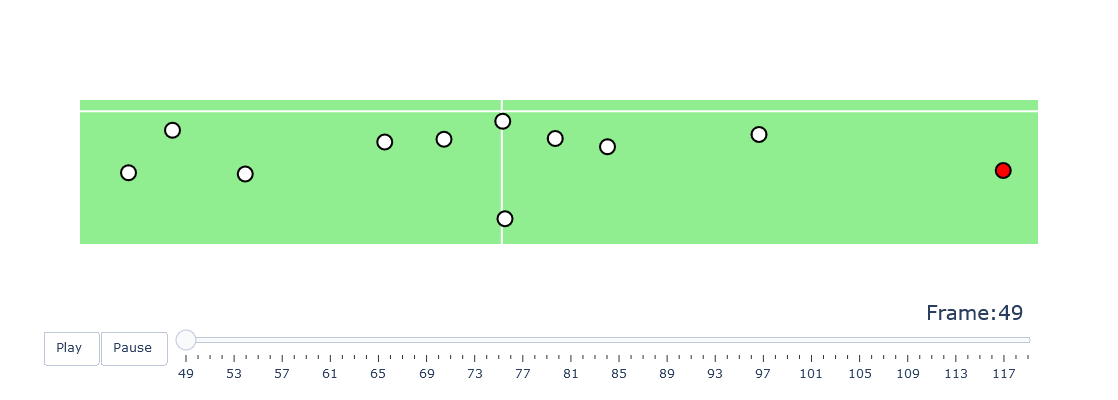

In [290]:
gid = 2022091105
pid = 1809

animate_play_vertical(games=games, tracking_df=tracking_df,
             play_df=plays, players=players, gameId=gid,
             playId=pid)